In [499]:
import numpy as np
import pandas as pd
import sys
import argparse
import matplotlib.pyplot as plt 
%matplotlib inline
plt.style.use('ggplot')
from sklearn import linear_model
from sklearn.model_selection import train_test_split
import os
from sklearn.feature_selection import SelectKBest, f_regression, VarianceThreshold
from sklearn.metrics import mean_squared_error
import math
cur_path = os.getcwd()

File/Data Pre-processing 
* Get file paths
* Generate the matrices, while dropping superfluous columns (#chr, start, end)
* Tranpose the matrices so that rows are patients and columns are gene expression features
* We then construct the labels for each tissue. For the age column in our file, we are given 10-year ranges of age for each patient (for example 60-69). I chose to represent an age range as an integer value of the first digit in the range. So for the range 60-69, I encoded this as 6, since we cannot infer anything else. I am choosing to represent age as a continuous value rather than a classification label because there is inherently a hierarchical structure to age. The age range 70-79 not only communicates belonging to class, but it also communicates that it is greater than the class 60-69 and less than the class 80-89. For this reason, it only makes sense to model the problem as a regression.
* The GTEx data is already normalized, so this step is not performed here.

In [500]:
# File parsing
parser = argparse.ArgumentParser(description='Process display arguments')
parser.add_argument("-f", "--jupyter-json")
parser.add_argument("-adipose-file", "--adipose-file", default=cur_path+"/data/Adipose_Subcutaneous_Analysis.v6p.normalized.expression.bed")
parser.add_argument("-muscle-file", "--muscle-file", default=cur_path+"/data/Muscle_Skeletal_Analysis.v6p.normalized.expression.bed")
parser.add_argument("-thyroid-file", "--thyroid-file", default=cur_path+"/data/Thyroid_Analysis.v6p.normalized.expression.bed")
parser.add_argument("-whole-blood-file", "--whole-blood-file", default=cur_path+"/data/Whole_Blood_Analysis.v6p.normalized.expression.bed")
parser.add_argument("-label-file", "--label-file", default=cur_path+"/data/GTEx_Data_V6_Annotations_SubjectPhenotypesDS.txt")
args = parser.parse_args()

# Matrix generation
def gen_matrix(file_path):
    df = pd.read_csv(file_path, header=0, sep='\t', dtype=str)
    df.drop(["#chr", "start", "end"], axis=1, inplace=True)
    df.set_index("gene_id", inplace=True)
    df = df.transpose()
    df.columns.name = None
    return df.apply(pd.to_numeric)
    
adipose = gen_matrix(args.adipose_file)
muscle = gen_matrix(args.muscle_file)
thyroid = gen_matrix(args.thyroid_file)
whole_blood = gen_matrix(args.whole_blood_file) 

In [501]:
# Construct label sets for each tissue
labels = pd.read_csv(args.label_file, header=0, sep='\t', dtype=str)
labels = labels.set_index("SUBJID").drop(["GENDER", "DTHHRDY"], axis=1)
labels.index.name = None
labels["AGE"] = labels["AGE"].apply(lambda x: int(x[0:2]))

adipose_labels = labels.loc[adipose.index].copy()
muscle_labels = labels.loc[muscle.index].copy()
thyroid_labels = labels.loc[thyroid.index].copy()
whole_blood_labels = labels.loc[whole_blood.index].copy()

Data Processing
* Perform the training-testing split. 
* Select top 1000 features based on univariate correlations (f-regression)

In [512]:
# Feature selection--solely based on training data and labels
def select_features(data_tup):
    train_x, test_x, train_y, test_y = data_tup
    selector = SelectKBest(f_regression, k=1000)
    selector.fit(train_x, train_y)
    col_indices = selector.get_support(indices=True)
    return train_x[col_indices], test_x[col_indices], train_y, test_y

# Training-testing splits for each tissue
adipose_train, adipose_test, adipose_labels_train, adipose_labels_test = select_features(train_test_split(adipose, adipose_labels, test_size=0.30, random_state=1))
muscle_train, muscle_test, muscle_labels_train, muscle_labels_test = select_features(train_test_split(muscle, muscle_labels, test_size=0.30, random_state=1))
thyroid_train, thyroid_test, thyroid_labels_train, thyroid_labels_test = select_features(train_test_split(thyroid, thyroid_labels, test_size=0.30, random_state=1))
whole_blood_train, whole_blood_test, whole_blood_labels_train, whole_blood_labels_test = select_features(train_test_split(whole_blood, whole_blood_labels, test_size=0.30, random_state=1))

CV Hyperparameter tuning
* Return the optimal lambda on the cv testing over the training data. Uses leave one out. 

In [503]:
def get_lambda(df, labels):
    regr_cv = linear_model.RidgeCV(alphas=[0.1, 1.0, 10.0, 100], store_cv_values=True)
    regr_cv.fit(df, labels)
    return regr_cv.alpha_

adipose_lambda = get_lambda(adipose_train, adipose_labels_train)
muscle_lambda = get_lambda(muscle_train, muscle_labels_train)
thyroid_lambda = get_lambda(thyroid_train, thyroid_labels_train)
whole_blood_lambda = get_lambda(whole_blood_train, whole_blood_labels_train)

Prediction
* Predict over increments of training examples (of size 10)
* Use RMSE to record accuracy

In [504]:
num_examples = range(50, 300, 10)
tissues = ["adipose", "muscle", "thyroid", "whole_blood"]
results = pd.DataFrame(index=tissues, columns=num_examples)
results.index.name = "Tissue"
results.columns.name = "Number of Training Examples"

In [505]:
adipose_model = linear_model.Ridge(alpha=adipose_lambda)
muscle_model = linear_model.Ridge(alpha=muscle_lambda)
thyroid_model = linear_model.Ridge(alpha=thyroid_lambda)
whole_blood_model = linear_model.Ridge(alpha=whole_blood_lambda)

for i in num_examples:
    adipose_model.fit(adipose_train.head(i), adipose_labels_train.head(i))
    adipose_pred = adipose_model.predict(adipose_test)
    results.at["adipose", i] = math.sqrt(mean_squared_error(adipose_labels_test, adipose_pred))
    
    muscle_model.fit(muscle_train.head(i), muscle_labels_train.head(i))
    muscle_pred = muscle_model.predict(muscle_test)
    results.at["muscle", i] = math.sqrt(mean_squared_error(muscle_labels_test, muscle_pred))
    
    thyroid_model.fit(thyroid_train.head(i), thyroid_labels_train.head(i))
    thyroid_pred = thyroid_model.predict(thyroid_test)
    results.at["thyroid", i] = math.sqrt(mean_squared_error(thyroid_labels_test, thyroid_pred))
    
    whole_blood_model.fit(whole_blood_train.head(i), whole_blood_labels_train.head(i))
    whole_blood_pred = whole_blood_model.predict(whole_blood_test)
    results.at["whole_blood", i] = math.sqrt(mean_squared_error(whole_blood_labels_test, whole_blood_pred))
    

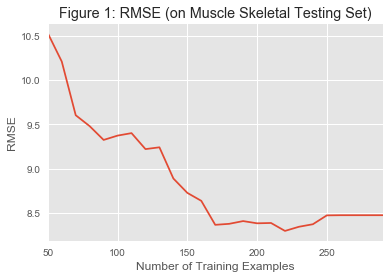

In [506]:
ax = results.transpose()["muscle"].plot()
ax.set_title("Figure 1: RMSE (on Muscle Skeletal Testing Set)")
ax.set_ylabel("RMSE")
plt.savefig(cur_path+"/results/figure_1.pdf", format="pdf")

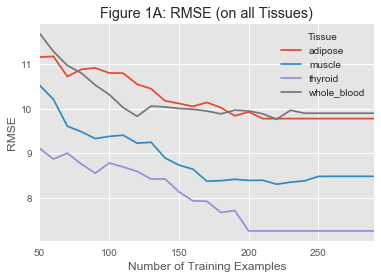

In [507]:
ax = results.transpose().plot()
ax.set_title("Figure 1A: RMSE (on all Tissues)")
ax.set_ylabel("RMSE")
plt.savefig(cur_path+"/results/figure_1A.pdf", format="pdf")

In [508]:
b_results = pd.DataFrame(index=tissues, columns=["total_samples", "smallest_same_number_samples"])
common_num_samples = thyroid_train.shape[0]

In [509]:
adipose_model.fit(adipose_train, adipose_labels_train)
adipose_pred = adipose_model.predict(adipose_test)
b_results.at["adipose", "total_samples"] = math.sqrt(mean_squared_error(adipose_labels_test, adipose_pred))

adipose_model.fit(adipose_train.head(common_num_samples), adipose_labels_train.head(common_num_samples))
adipose_pred = adipose_model.predict(adipose_test)
b_results.at["adipose", "smallest_same_number_samples"] = math.sqrt(mean_squared_error(adipose_labels_test, adipose_pred))

muscle_model.fit(muscle_train, muscle_labels_train)
muscle_pred = muscle_model.predict(muscle_test)
b_results.at["muscle", "total_samples"] = math.sqrt(mean_squared_error(muscle_labels_test, muscle_pred))

muscle_model.fit(muscle_train.head(common_num_samples), muscle_labels_train.head(common_num_samples))
muscle_pred = muscle_model.predict(muscle_test)
b_results.at["muscle", "smallest_same_number_samples"] = math.sqrt(mean_squared_error(muscle_labels_test, muscle_pred))

thyroid_model.fit(thyroid_train, thyroid_labels_train)
thyroid_pred = thyroid_model.predict(thyroid_test)
b_results.at["thyroid", "total_samples"] = math.sqrt(mean_squared_error(thyroid_labels_test, thyroid_pred))

thyroid_model.fit(thyroid_train.head(common_num_samples), thyroid_labels_train.head(common_num_samples))
thyroid_pred = thyroid_model.predict(thyroid_test)
b_results.at["thyroid", "smallest_same_number_samples"] = math.sqrt(mean_squared_error(thyroid_labels_test, thyroid_pred))

whole_blood_model.fit(whole_blood_train, whole_blood_labels_train)
whole_blood_pred = whole_blood_model.predict(whole_blood_test)
b_results.at["whole_blood", "total_samples"] = math.sqrt(mean_squared_error(whole_blood_labels_test, whole_blood_pred))

whole_blood_model.fit(whole_blood_train.head(common_num_samples), whole_blood_labels_train.head(common_num_samples))
whole_blood_pred = whole_blood_model.predict(whole_blood_test)
b_results.at["whole_blood", "smallest_same_number_samples"] = math.sqrt(mean_squared_error(whole_blood_labels_test, whole_blood_pred))

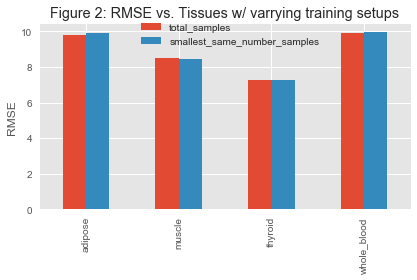

In [520]:
ax = b_results.plot(kind='bar')
ax.set_title("Figure 2: RMSE vs. Tissues w/ varrying training setups")
ax.set_ylabel("RMSE")
plt.legend(bbox_to_anchor=(0.25, 1.05))
#plt.gcf().subplots_adjust(bottom=0.30)
#plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=2, mode="expand", borderaxespad=0.)
plt.tight_layout()
plt.savefig(cur_path+"/results/figure_2.pdf", format="pdf")